<a href="https://colab.research.google.com/github/donggrant/sign-language-interface/blob/master/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from PIL import Image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from pipey import Pipeable

In [2]:
!wget https://github.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/raw/master/Dataset.zip
!unzip Dataset.zip

--2022-04-21 20:05:57--  https://github.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/raw/master/Dataset.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/master/Dataset.zip [following]
--2022-04-21 20:05:57--  https://raw.githubusercontent.com/mon95/Sign-Language-and-Static-gesture-recognition-using-sklearn/master/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33742153 (32M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  32.18M   115MB/s    in 0.3s 

In [3]:
!pip install pipey

  Created wheel for pipey: filename=pipey-0.0.1a5-py3-none-any.whl size=6238 sha256=bfdf226ebc743b2a9d0072740123eeeefa3ec0061ce85a7d86585bff6e85eccb
  Stored in directory: /root/.cache/pip/wheels/22/fe/03/da0cb9a7ee105be11d418539934567afbe290d05b1e3fdd926
Successfully built pipey


In [5]:
path = 'Dataset/'
list_of_files = [x[1] for x in list(filter(lambda f: ('.jpg' in f[0]) or ('.csv' in f[0]),[ (file, os.sep.join((dir, file)))
                       for (dir,dirs,files) in os.walk(path)
                       for file in files]))]
list_of_csvs = list(filter(lambda f: '.csv' in f, list_of_files))
list_of_files = list(filter(lambda f: '.jpg' in f, list_of_files))
list_of_files.sort()
list_of_csvs.sort()

In [8]:
crop_dimensions = map(
    lambda df: [
                (df.iloc[i]["top_left_x"],
                            df.iloc[i]["top_left_y"],
                            df.iloc[i]["bottom_right_x"],
                            df.iloc[i]["bottom_right_y"]) for i in range(len(df)) 
    ] , map(pd.read_csv, list_of_csvs)) >> Pipeable(lambda f: [j for i in f for j in i])

In [11]:
X = np.asarray(list(map(
    lambda k: np.asarray(Image.open(k[0]).crop(k[1]).resize((128,128)))
    , zip(list_of_files, crop_dimensions))))

y = np.asarray(list(map(
    lambda k: k[:-5][-1:]
    , list_of_files)))

(1680, 128, 128, 3) (1680,)
E


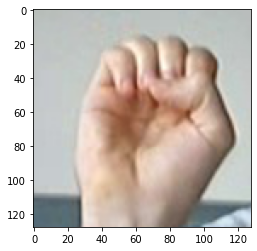

In [14]:
print(X.shape, y.shape)
print(y[1000])
plt.imshow(X[1000])

In [15]:
def augment(image, lab):
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, 0.5, 1)
  return (image, lab)

tup_list = list(
    map(
        lambda tup: [augment(tup[0], tup[1]) for i in range(3)] + [tup],
        zip(X, y)
        )
    )

Y


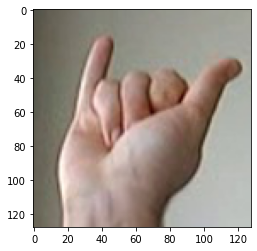

In [16]:
images, lables = list(zip(*[item for perms in tup_list for item in perms]))
X = np.asarray(images)
y = np.asarray(lables)
print(y[-1])
plt.imshow(X[-1])

In [17]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y' ]
y_bin = le.fit(class_names)
y = y_bin.fit_transform(y)

from sklearn.model_selection import train_test_split
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size = 0.4, random_state = 12345)
X_eval, X_test, y_eval, y_test = train_test_split(X_valtest, y_valtest, test_size = 0.5, random_state = 12345)

In [18]:
train_n = len(X_train)
test_n = len(X_test)

print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

Number of training images:  4032
Number of testing images:  1344
Number of evaluation images:  1344


In [19]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_eval = to_categorical(y_eval)

In [20]:
print(y_train[0])
print(len(y_train[0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
24


In [21]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

In [29]:
image_height = 128
image_width = 128

#Initialising vgg16 
classifier_vgg16 = VGG16(input_shape= (image_height,image_width,3),include_top=False,weights='imagenet')
#Initialising resnet50 
classifier_resnet = ResNet50(input_shape=(image_height,image_width,3),include_top=False,weights='imagenet')

#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

#don't train existing weights for resnet50
for layer in classifier_resnet.layers:
    layer.trainable = False

In [30]:
#VGG16
classifier1 = classifier_vgg16.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=24, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#resnet50
classifier2 = classifier_resnet.output#head mode
classifier2 = Flatten()(classifier2)#adding layer of flatten
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=24, activation='softmax')(classifier2)

model2 = Model(inputs = classifier_resnet.input , outputs = classifier2)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
#fit the model
#it will take some time to train
#vgg16
history = model.fit(X_train, y_train, epochs =10, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/10
63/63 [==============================] - 10s 150ms/step - loss: 1.9263 - accuracy: 0.4392 - val_loss: 0.6724 - val_accuracy: 0.9196
Epoch 2/10
63/63 [==============================] - 9s 149ms/step - loss: 0.7966 - accuracy: 0.7708 - val_loss: 0.2534 - val_accuracy: 0.9844
Epoch 3/10
63/63 [==============================] - 9s 150ms/step - loss: 0.5001 - accuracy: 0.8611 - val_loss: 0.1351 - val_accuracy: 0.9911
Epoch 4/10
63/63 [==============================] - 9s 150ms/step - loss: 0.3542 - accuracy: 0.9028 - val_loss: 0.0903 - val_accuracy: 0.9955
Epoch 5/10
63/63 [==============================] - 9s 142ms/step - loss: 0.2769 - accuracy: 0.9229 - val_loss: 0.0475 - val_accuracy: 1.0000
Epoch 6/10
63/63 [==============================] - 9s 148ms/step - loss: 0.2172 - accuracy: 0.9452 - val_loss: 0.0410 - val_accuracy: 0.9970
Epoch 7/10
63/63 [==============================] - 9s 149ms/step - loss: 0.1826 - accuracy: 0.9559 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch

In [ ]:
#fit the model
#resnet50
history2 = model2.fit(X_train, y_train, epochs =100, batch_size = 64,validation_data=(X_test,y_test))

In [32]:
# Accuracy of VGG16
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 100.0 %
Accuracy for evaluation images: 99.926 %


In [ ]:
# Accuracy of RESNET50
score = model2.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model2.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Camera Testing

In [33]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


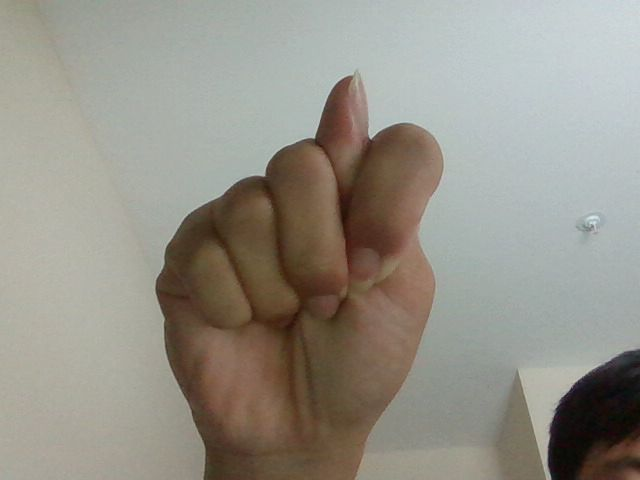

N

In [115]:
import numpy as np
import cv2
from IPython.display import Image
from keras.preprocessing.image import img_to_array, load_img

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
  
from PIL import Image
# Preprocess image for model
img = Image.open(filename)
img = np.asarray(img)
img = cv2.resize(img,(128,128))
img = img.reshape(1, 128, 128,3)
output = model.predict(img)[0]
sign = class_names[np.argmax(output)]
print(sign, end="")

In [116]:
model.save("TF_model.h5")